In [1]:
#setup
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import gensim

sns.set_theme()
plt.rcParams["figure.figsize"] = (10,8)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from main import nlp_pipeline_result

In [3]:
"""
data_non_ner = nlp_pipeline_result(
    disable_ner=False,
    parameters={
        "remove_hashtag_word": True,
        "replace_politics": True,
        "replace_parties": True,
    }
)
data_non_ner['n_lemmas'] = data_non_ner['Lemmas'].str.split().str.len()

data_non_ner.to_csv('data/data.csv', index = False)
"""

'\ndata_non_ner = nlp_pipeline_result(\n    disable_ner=False,\n    parameters={\n        "remove_hashtag_word": True,\n        "replace_politics": True,\n        "replace_parties": True,\n    }\n)\ndata_non_ner[\'n_lemmas\'] = data_non_ner[\'Lemmas\'].str.split().str.len()\n\ndata_non_ner.to_csv(\'data/data.csv\', index = False)\n'

In [4]:
data = pd.read_csv('data/data.csv')


In [5]:


train = data.sample(frac = 0.8, random_state = 420)
test = data.drop(train.index)

print("Len data: ", len(data))
print("Len train: ", len(train))
print("Len test: ", len(test))


data = train

Len data:  14792
Len train:  11834
Len test:  2958


In [6]:
for i in range(0,50,10):
    display(data[i:i+10])

,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
9822,@Tyler287w Pues no le pregunté. Pero yo lo ten...,Pues no le pregunté. Pero yo lo tengo claro. Q...,438,16,Macarena Olona Choclán,Vox,preguntar momento difícil,3
7882,A todos los cantamañanas les da por interveni...,A todos los cantamañanas les da por intervenir...,51,15,Rubén Silvano Manso Olivar,Vox,cantamañana intervenir Economía Derecho interv...,9
559,Sánchez donará en su nombre pero con el dinero...,Sánchez donará en su nombre pero con el dinero...,147,87,Francisco José Alcaraz Martos,Vox,Sánchez donar nombre dinero español saquear bo...,10
2943,🔵 Comité Ejecutivo Nacional del PP.🎥 ¡Sigue mi...,🔵 Comité Ejecutivo Nacional del PP.🎥 ¡Sigue mi...,299,94,Pablo Casado Blanco,PP,Comité Ejecutivo Nacional PP intervención 𝐝𝐢𝐫𝐞𝐜𝐭𝐨,6
7950,Una enorme lástima que el PSOE mantuviera a Án...,Una enorme lástima que el PSOE mantuviera a Án...,2,4,Pilar Marcos Domínguez,PP,enorme lástima PSOE mantener Ángel Gabilondo n...,16
958,¡Empecemos a hablar con propiedad Señorías de ...,¡Empecemos a hablar con propiedad Señorías de ...,14,8,José Ángel Alonso Pérez,PP,hablar propiedad Señorías izquierda,4
11191,El discurso de odio y la falta de respeto a lo...,El discurso de odio y la falta de respeto a lo...,20,7,María Tamara Raya Rodríguez,PSOE,discurso odio falta respeto valor democrático ...,19
12064,#SoloQuedaVOX#YoConMonasterio👏🏻👏🏻👏🏻💪🏻💪🏻Bravo!!...,Jajaja Pablo cierra al salir.,139,46,Patricia Rueda Perelló,Vox,Jajaja Pablo cerrar salir,4
7142,‼️🇪🇸 sencillamente me ha encantado @MargaPisa🇪...,‼️🇪🇸 sencillamente me ha encantado vía,6,2,Rodrigo Jiménez Revuelta,Vox,encantar vía,2
2940,No es la desigualdad la que trae el socialismo...,No es la desigualdad la que trae el socialismo...,489,166,Pablo Casado Blanco,PP,desigualdad traer socialismo socialismo traer ...,16


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
10426,"Hasta el final, vaya gente comprometida la de ...","Hasta el final, vaya gente comprometida la de ...",24,2,Víctor Valentín Píriz Maya,PP,gente comprometido crack,3
12293,A que es enormemente tranquilizante- y sin dud...,A que es enormemente tranquilizante- y sin dud...,90,39,Víctor Manuel Sánchez del Real,Vox,duda levantar alarma necesitar tabla fila dece...,12
11385,La Violencía es intolerable.,La Violencía es intolerable.,6,3,Carmen Riolobos Regadera,PP,Violencía intolerable,2
9204,Guía para los trabajadores en las elecciones e...,Guía para los trabajadores en las elecciones e...,5,2,Lucía Muñoz Dalda,Unidas Podemos,Guía trabajador elección Madrid mayo votar lab...,7
864,Se amplían los sectores pero no la cuantía de ...,Se amplían los sectores pero no la cuantía de ...,9,10,Agustín Almodóbar Barceló,PP,amplíar sector cuantía ayuda directo repartir ...,7
1192,A estas alturas todos sabemos que la candidata...,A estas alturas todos sabemos que la candidata...,6,2,Francisco Aranda Vargas,PSC,altura candidata ausente ultra derecha actual ...,12
5890,Solo hay una receta para mantener a Madrid lib...,Solo hay una receta para mantener a Madrid lib...,713,267,Teodoro García Egea,PP,receta mantener Madrid libre Partido Popular,6
4572,@Souto002 Tú niegas la necesidad del debate pú...,Tú niegas la necesidad del debate público y yo...,0,0,Odón Elorza González,PSE-EE-PSOE,niegas necesidad debate público reafirmar cree...,17
358,Intolerable,Intolerable,588,220,Francisco José Alcaraz Martos,Vox,intolerable,1
10205,Gracias a mis compañeros del @ppchamberi y esp...,Gracias a mis compañeros del y especialmente a...,276,59,Ana María Pastor Julián,PP,gracias compañero persona acercar mostrar apoyo,6


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
8142,Madrid NO quiere votar a ⁦@PabloIglesias⁩. Hay...,Madrid NO quiere votar a Hay motivo. Muchos mo...,92,37,Pilar Marcos Domínguez,PP,Madrid votar motivo motivo votar motivo motivo,7
4784,@eva_baroja Todo está en la vida cotidiana,Todo está en la vida cotidiana,6,1,Íñigo Errejón Galván,Más País-Equo,vida cotidiano,2
8589,Eres muy grande querido @BalEdmundo Sin duda e...,Eres muy grande querido Sin duda eres el mejor...,57,19,María Carmen Martínez Granados,Ciudadanos,grande querido duda candidato,4
2107,Esta tarde acude a escuchar a @Santi_ABASCAL y...,Esta tarde acude a escuchar a y en la Plaza de...,6,3,Pablo Juan Calvo Liste,Vox,acudir escuchar Plaza España San Fernando,6
2283,@Cristina_H_ De construcción masiva 😉,De construcción masiva 😉,8,0,Pilar Cancela Rodríguez,PSdeG-PSOE,construcción masivo,2
1513,Más de 2.500 jueces han alertado de la amenaza...,Más de 2.500 jueces han alertado de la amenaza...,536,233,Edmundo Bal Francés,Ciudadanos,juez alertar amenaza suponer democracia aument...,19
1692,🎨¡Feliz #DíaMundialDelArte!El @Congreso_Es ate...,🎨¡Feliz atesora una importante colección artís...,112,17,Meritxell Batet Lamaña,PSC,Feliz atesorar importante colección artístico ...,18
12036,"En Jerez de la Frontera, en ma bodega Valdespi...","En Jerez de la Frontera, en ma bodega Valdespi...",197,66,Agustín Rosety Fernández de Castro,Vox,Jerez Frontera ma bodega Valdespino compañero ...,14
4827,@ropadeletras @htejero_ @joanbaldovi Un abrazo...,Un abrazo y cuídate,2,0,Íñigo Errejón Galván,Más País-Equo,abrazo cuídate,2
985,@PabloEchenique 🔴 Más de cien millones de muer...,🔴 Más de cien millones de muertos. ☠️ La ideol...,7,2,José Ángel Alonso Pérez,PP,millón muerto ideología asesino historia Human...,6


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
14742,Se llama José CoronadoEs un gran actor Es buen...,Se llama José CoronadoEs un gran actor Es buen...,1465,405,José Zaragoza Alonso,PSC,llamar José CoronadoEs actor personaes sensato...,13
8869,Impuesto de Circulación+Impuesto de Matriculac...,Impuesto de Circulación+Impuesto de Matriculac...,33,14,Manuel Mestre Barea,Vox,impuesto excesivo azul verde naranja amarillo ...,10
12519,Al final el “periodista de investigación” se i...,Al final el “periodista de investigación” se i...,111,45,Víctor Manuel Sánchez del Real,Vox,periodista investigación inventar cosa confron...,12
6087,@FrandeleonPP @pablocasado_ @populares @GPPopu...,"PP PP Ya me dirás, Fran. No te libras de un ti...",2,1,Alicia García Rodríguez,PP,PP PP dirás Fran librar tiron oreja,7
7463,Grandísimo en todo el pleno sentido de definic...,Grandísimo en todo el pleno sentido de definic...,0,1,Fuensanta Lima Cid,PSOE,grandísimo pleno sentido definición persona,5
12281,Gran iniciativa de @VoxCortesCyL1 y @pinacho_f...,Gran iniciativa de y Luchar contra la despobla...,37,20,Pablo Sáez Alonso-Muñumer,Vox,iniciativo luchar despoblación proponer medida...,7
5729,El ministro Uribes descarta la vuelta del públ...,El ministro Uribes descarta la vuelta del públ...,0,1,Óscar Gamazo Micó,PP,ministro Uribes descartar vuelta público estad...,10
6455,Abascal nos enseña un adoquín. Lo levanta con ...,Abascal nos enseña un adoquín. Lo levanta con ...,195,85,Antonio Gómez-Reino Varela,En Común,Abascal enseñar adoquín levantar mano víctima ...,17
311,🔷Gaurko gomendioa / Mi recomendación de artícu...,🔷Gaurko gomendioa / Mi recomendación de artícu...,24,10,Mertxe Aizpurua Arzallus,EH Bildu,Gaurko gomendioa recomendación artículo duda n...,11
14316,Tenéis que ver a @PabloIglesias #DemocraciaOFa...,Tenéis que ver a,20,16,Martina Velarde Gómez,Unidas Podemos,tenéis,1


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
4583,@Desiderio2015 Lo mejor .. el aislamiento demo...,Lo mejor .. el aislamiento democrático de la e...,24,13,Odón Elorza González,PSE-EE-PSOE,aislamiento democrático extremo derecha derrot...,9
12052,Cierre Campaña Colón. Cuando sonríes con el al...,Cierre Campaña Colón. Cuando sonríes con el al...,573,116,Patricia Rueda Perelló,Vox,Cierre Campaña Colón sonríes alma valient quer...,14
5872,En estas elecciones se ha elegido entre modelo...,En estas elecciones se ha elegido entre modelo...,313,159,Teodoro García Egea,PP,elección elegir modelo president autonómico PP...,15
7524,Socialismo es Libertad. A votar Madrid. Por la...,Socialismo es Libertad. A votar Madrid. Por la...,15,10,Ignacio López Cano,PSOE,Socialismo Libertad votar Madrid Libertad pagá...,6
13223,El Gobierno de España va a ampliar en 200 M€ l...,El Gobierno de España va a ampliar en 200 M€ l...,230,96,Pedro Sánchez Pérez-Castejón,PSOE,Gobierno España ampliar cobertura seguro ofici...,19
2074,"“Ahora los niños ya no vienen de Paris, vienen...","“Ahora los niños ya no vienen de Paris, vienen...",96,57,Pablo Juan Calvo Liste,Vox,niño venir Paris venir África palabra Defensor...,20
12938,Hoy carpeta borradores llena. Somos dueños de...,Hoy carpeta borradores llena. Somos dueños de ...,331,67,Víctor Manuel Sánchez del Real,Vox,carpeta borrador lleno dueño silencio esclavo ...,16
5533,Mi agradecimiento y el de mis compañeros diput...,Mi agradecimiento y el de mis compañeros diput...,855,248,Pedro Fernández Hernández,Vox,agradecimiento compañero diputado concejal asi...,9
1809,Hoy he estado visitando a los compañeros/as de...,Hoy he estado visitando a los compañeros/as de...,464,187,Ione Belarra Urteaga,Unidas Podemos,visitar compañero as querer agradecer militanc...,13
11541,La diferencia entre un señor como @sanchezdelr...,La diferencia entre un señor como y la gentuza...,92,27,Joaquín Robles López,Vox,diferencia señor gentuza delincuente tirar pie...,14


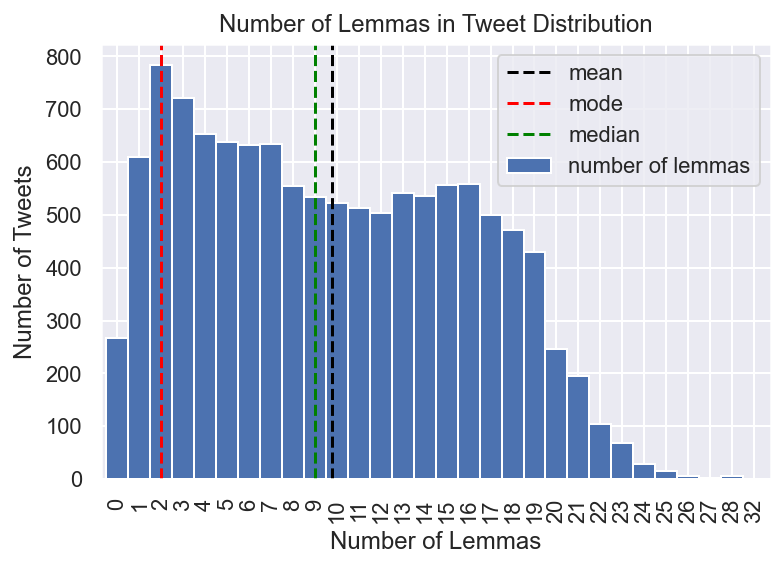

In [7]:
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(kind="bar",width=1,label='number of lemmas')
plt.axvline(x = data['n_lemmas'].mean(),label='mean',color = 'black',linestyle = '--')
plt.axvline(x = data['n_lemmas'].mode()[0],label='mode',color = 'red',linestyle = '--')
plt.axvline(x = data['n_lemmas'].median(),label='median',color = 'green',linestyle = '--')
plt.legend()
plt.title('Number of Lemmas in Tweet Distribution')
plt.xlabel('Number of Lemmas')
plt.ylabel('Number of Tweets')
plt.show()

In [8]:
data = data[data['n_lemmas']>=3]
print('Number of Tweets in Dataframe after removing short tweets:', len(data))

Number of Tweets in Dataframe after removing short tweets: 10173


In [9]:
tweets_corpus = data["Lemmas"].tolist()
tweets_corpus = list(set(tweets_corpus))
tweets_corpus = [el.split() for el in tweets_corpus]

# display(tweets_corpus)

In [10]:
from gensim.corpora import Dictionary

token_dic = Dictionary(tweets_corpus)


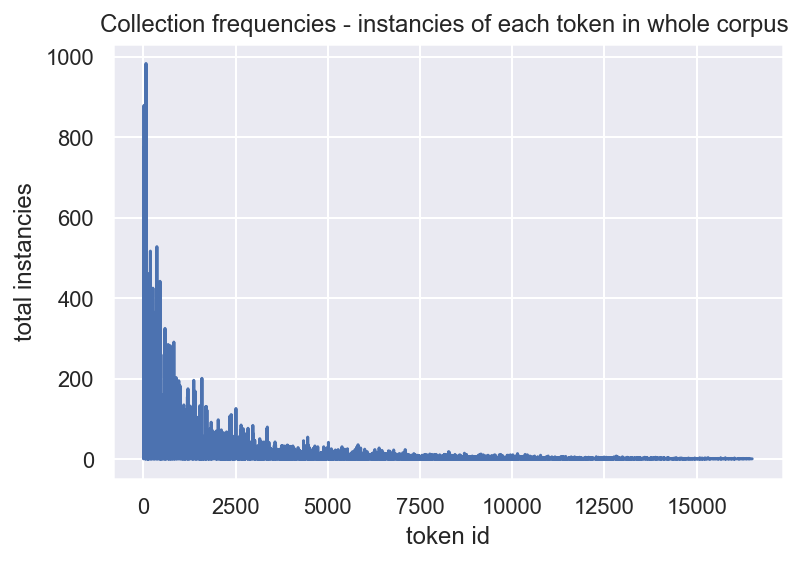

In [11]:
# Collection frequencies: token_id -> how many instances of this token are contained in the documents.

collfreq = token_dic.cfs.items()
collfreq = sorted(collfreq) 
x, y = zip(*collfreq) 
plt.plot(x, y)
plt.title('Collection frequencies - instancies of each token in whole corpus ')
plt.xlabel('token id')
plt.ylabel('total instancies')
plt.show()

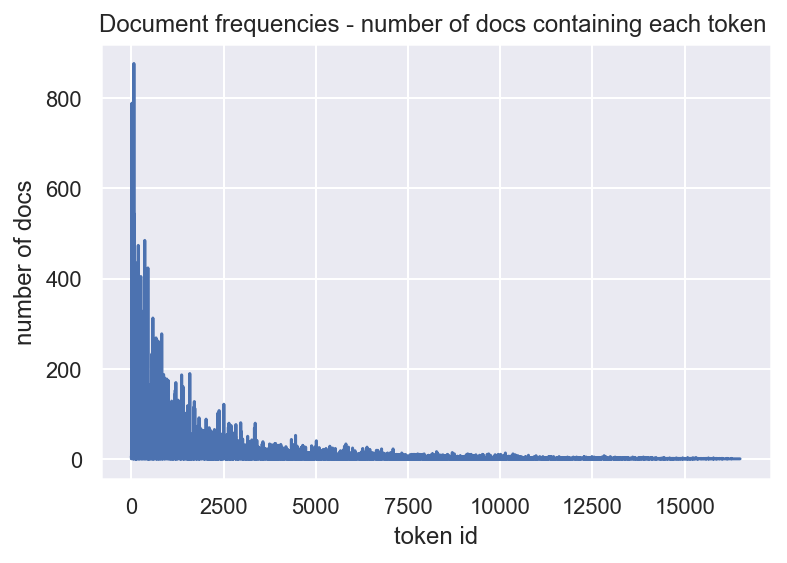

In [12]:
# Document frequencies: token_id -> how many documents contain this token


docfreq = token_dic.dfs.items()
docfreq = sorted(docfreq) 
j, k = zip(*docfreq) 
plt.plot(j, k)
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('token id')
plt.ylabel('number of docs')
plt.show()






In [13]:
#FILTER TOKEN DICTIONARY



no_below_list = [1,2,3,4,5,6,7,8,9,10] #Minimum number of documents to keep a term in the dictionary
no_above_list = [0.002, 0.004, 0.006, 0.008] #Maximum proportion of documents in which a term can appear to be kept in the dictionary

prev_dic = copy.copy(token_dic)
prev_tokens = len(token_dic)


print('The dictionary contained', prev_tokens, 'terms')

for i in no_below_list:
    
    for j in no_above_list:
        
        token_dic.filter_extremes(no_below=i,no_above=j)
        
        n_tokens = len(token_dic)
        
        print(n_tokens, 'terms |no_below = ', i, "| no_above = ", j)



#print('First terms in the dictionary:')
#for n in range(500):
#    print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY


The dictionary contained 16507 terms
15499 terms |no_below =  1 | no_above =  0.002
15499 terms |no_below =  1 | no_above =  0.004
15499 terms |no_below =  1 | no_above =  0.006
15499 terms |no_below =  1 | no_above =  0.008
6720 terms |no_below =  2 | no_above =  0.002
6720 terms |no_below =  2 | no_above =  0.004
6720 terms |no_below =  2 | no_above =  0.006
6720 terms |no_below =  2 | no_above =  0.008
4385 terms |no_below =  3 | no_above =  0.002
4385 terms |no_below =  3 | no_above =  0.004
4385 terms |no_below =  3 | no_above =  0.006
4385 terms |no_below =  3 | no_above =  0.008
3235 terms |no_below =  4 | no_above =  0.002
3235 terms |no_below =  4 | no_above =  0.004
3235 terms |no_below =  4 | no_above =  0.006
3235 terms |no_below =  4 | no_above =  0.008
2551 terms |no_below =  5 | no_above =  0.002
2551 terms |no_below =  5 | no_above =  0.004
2551 terms |no_below =  5 | no_above =  0.006
2551 terms |no_below =  5 | no_above =  0.008
2061 terms |no_below =  6 | no_above = 

In [14]:
token_dic = prev_dic 

print('The dictionary contains', len(token_dic), 'terms')


# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)

tweets_corpus_bow = [token_dic.doc2bow(doc) for doc in tweets_corpus]

# tweets_corpus_bow

The dictionary contains 16507 terms


In [15]:
from gensim.models.wrappers import LdaMallet
import os

os.environ['MALLET_HOME'] = r'C:/mallet'
mallet_path = 'C:/mallet/bin/mallet'
# mallet_path = '/Users/bernardobouzas/Downloads/mallet-2.0.8/bin/mallet'

ldamallet = LdaMallet(
    mallet_path,
    corpus=tweets_corpus_bow,
    num_topics=20,
    id2word=token_dic,
    alpha=5,
    iterations=100
)

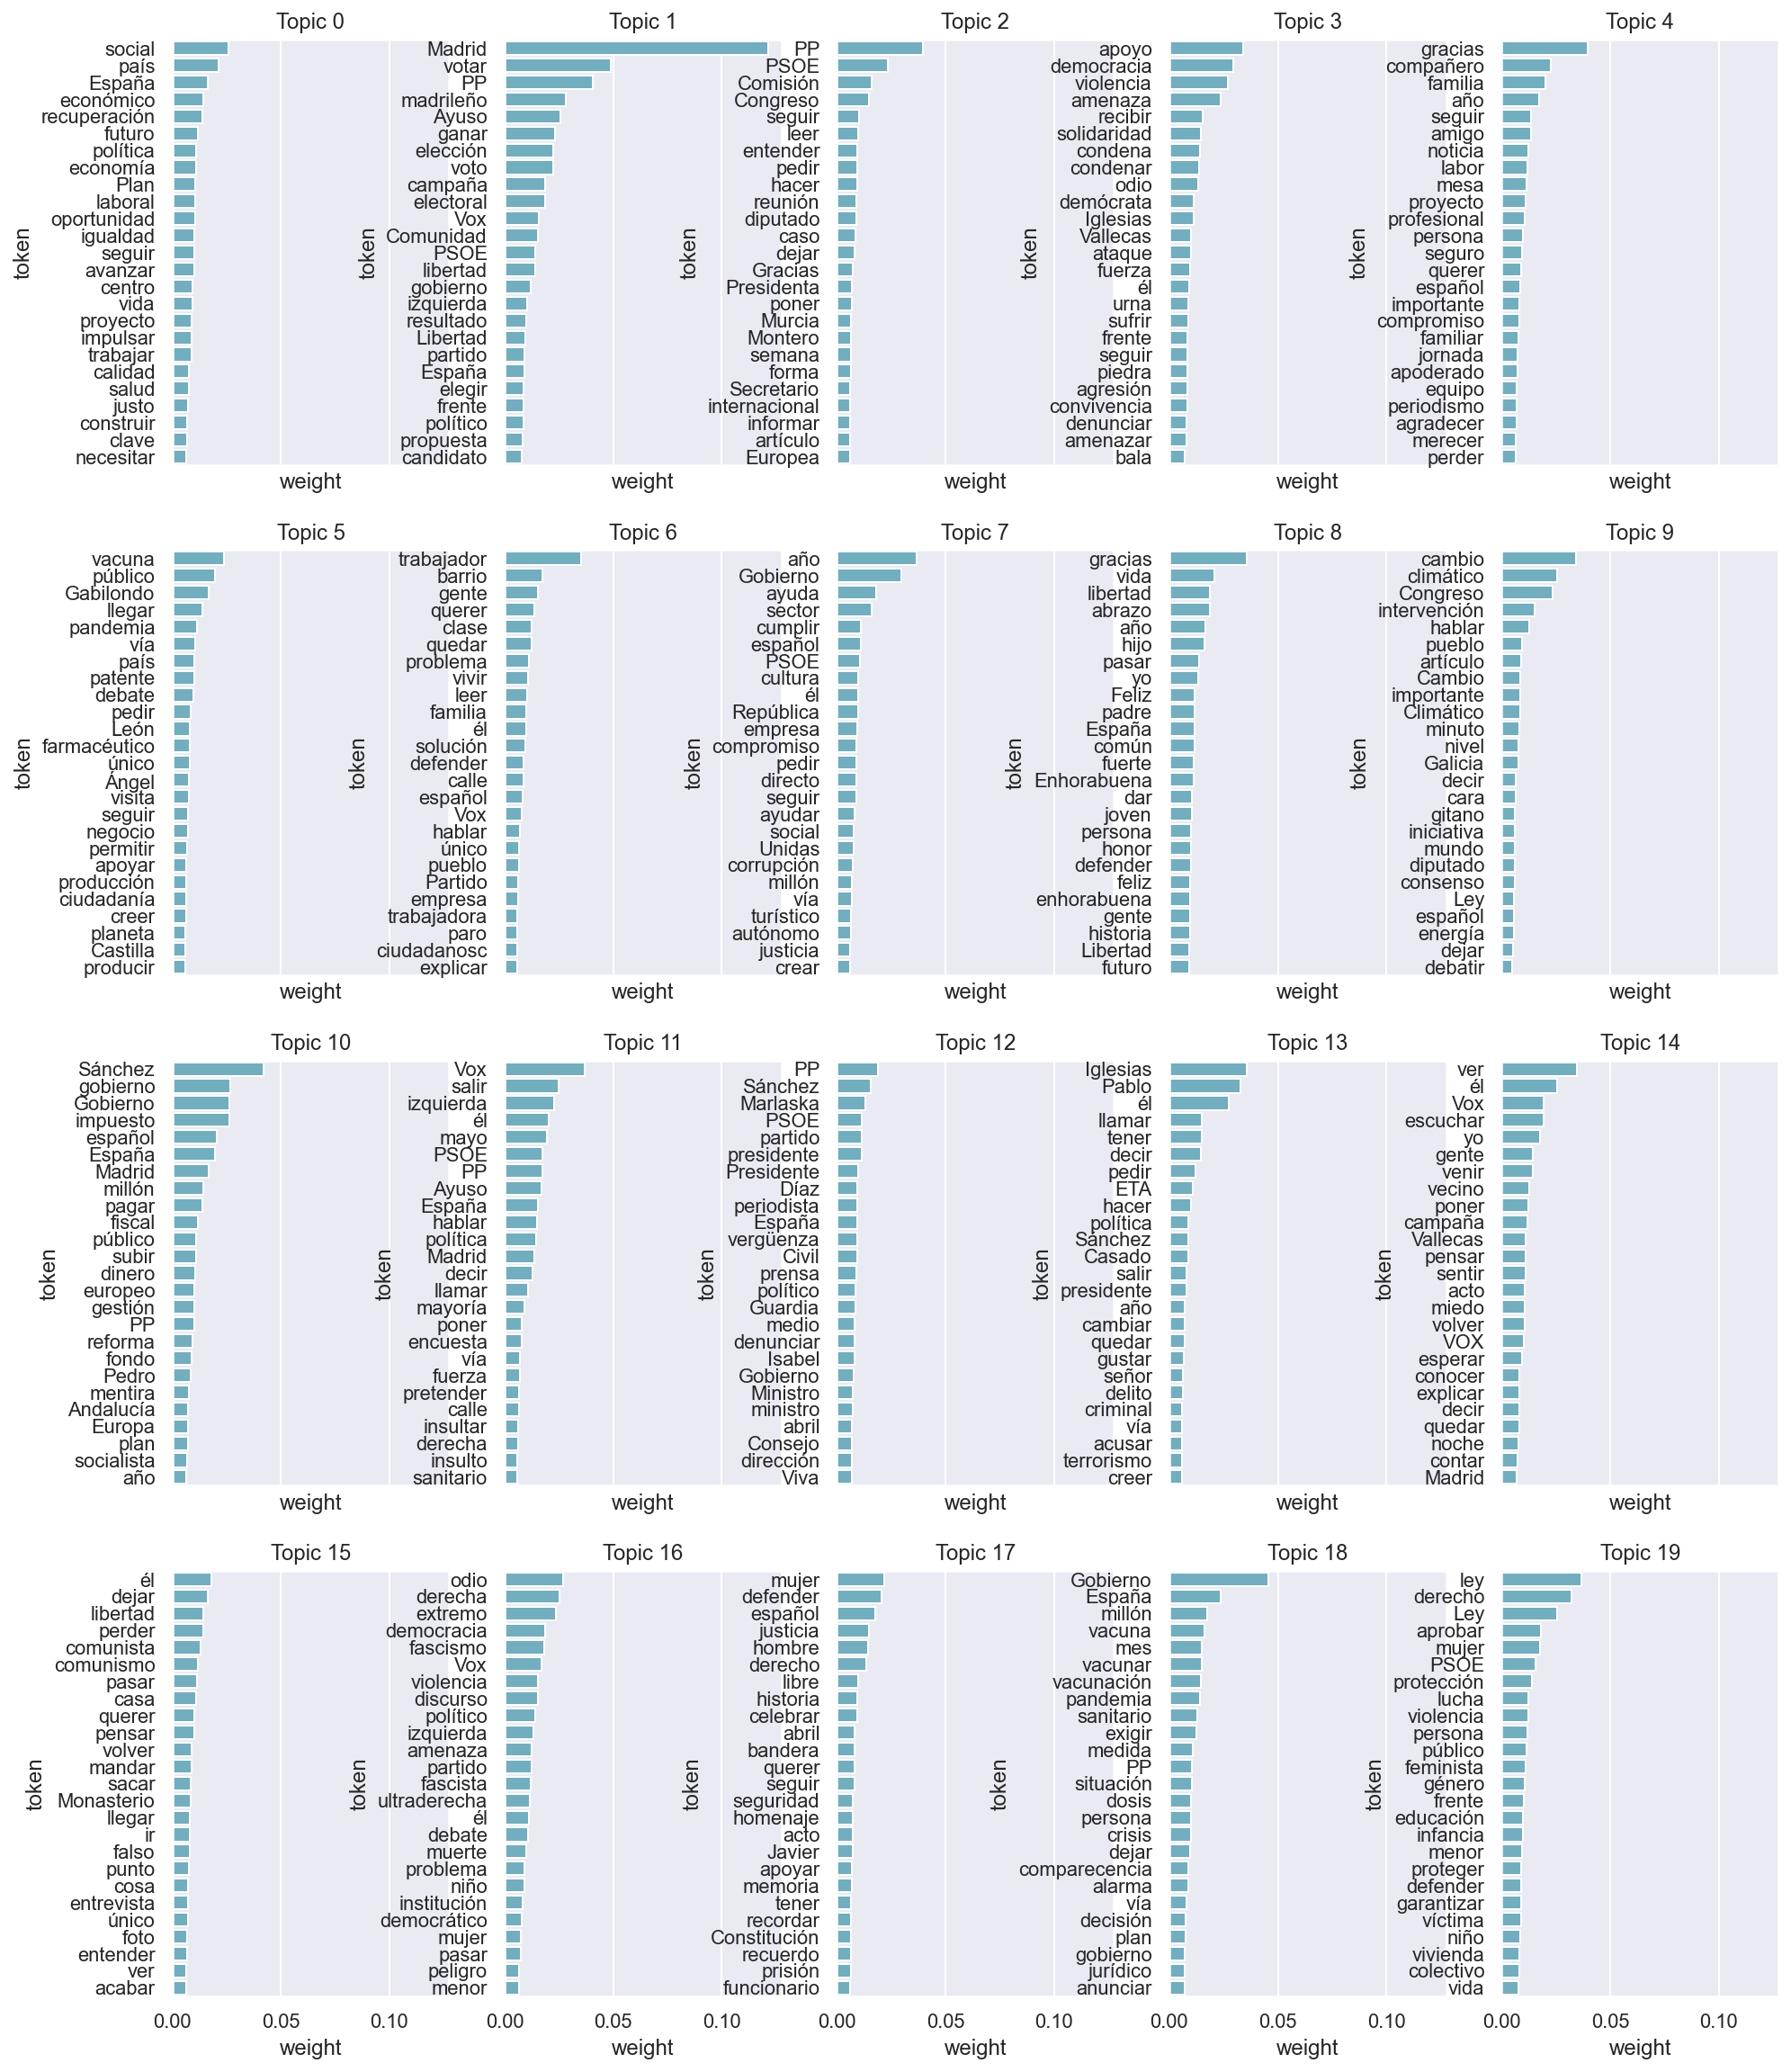

In [16]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)

for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(ldamallet.show_topic(i+5, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldamallet.show_topic(i+10, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 15
    df = pd.DataFrame(ldamallet.show_topic(i + 15, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 15))
    
plt.show()

# ///////// TASK 2 CLASIFICATION //////////

In [20]:
# print(list(ldamallet.load_document_topics()))
# print(len(list(ldamallet.load_document_topics())))


rec = []
for topic in ldamallet.load_document_topics():
    rec.append([value[1] for value in topic])
       
df = pd.DataFrame(rec)

print(len(df),len(data))

df['Likes'] = data["Likes"]
df['Retweets'] = data["Retweets"]
df["Party"] = data["Party"]


df = df[df['Party'].notna()]

print(len(df),len(data))

df


10006 10173
6817 10173


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,Likes,Retweets,Party
1,0.019231,0.250000,0.019231,0.019231,0.019231,0.019231,0.250000,0.019231,0.019231,0.019231,...,0.019231,0.173077,0.019231,0.019231,0.019231,0.019231,0.019231,770.0,326.0,PSOE
2,0.017857,0.017857,0.017857,0.017857,0.017857,0.017857,0.089286,0.017857,0.017857,0.017857,...,0.017857,0.089286,0.017857,0.017857,0.017857,0.375000,0.089286,653.0,222.0,PSOE
3,0.013158,0.013158,0.013158,0.013158,0.013158,0.118421,0.013158,0.013158,0.013158,0.013158,...,0.013158,0.223684,0.013158,0.118421,0.013158,0.013158,0.013158,167.0,77.0,PSOE
5,0.020833,0.020833,0.020833,0.020833,0.104167,0.020833,0.187500,0.020833,0.020833,0.020833,...,0.104167,0.020833,0.020833,0.020833,0.020833,0.187500,0.104167,421.0,211.0,PSOE
7,0.031250,0.031250,0.156250,0.031250,0.031250,0.031250,0.031250,0.031250,0.156250,0.031250,...,0.031250,0.156250,0.031250,0.031250,0.031250,0.031250,0.031250,352.0,136.0,PSOE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,0.013158,0.013158,0.065789,0.013158,0.118421,0.013158,0.013158,0.171053,0.013158,0.013158,...,0.013158,0.013158,0.013158,0.013158,0.013158,0.013158,0.434211,0.0,2.0,PP
10000,0.019231,0.096154,0.019231,0.019231,0.019231,0.019231,0.250000,0.096154,0.019231,0.019231,...,0.019231,0.096154,0.019231,0.019231,0.173077,0.019231,0.019231,2.0,2.0,PP
10001,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.483333,0.016667,0.016667,...,0.016667,0.016667,0.016667,0.016667,0.150000,0.016667,0.016667,7.0,0.0,PP
10002,0.118421,0.171053,0.013158,0.013158,0.013158,0.013158,0.013158,0.013158,0.013158,0.013158,...,0.118421,0.118421,0.013158,0.013158,0.013158,0.013158,0.013158,9.0,1.0,PP
